#### Voting Classifier
##### SEIS 763-01 - Prof. Lai
---
Charles Rehder | Krishna Chaitanya Bellamkonda | Mengyuan Cui | Soad Ahmed | Yang Yang

This notebook takes preprocessed data, builds a voting classifer model, and evaluates it with a variety of performance metrics. These performance metrics include the classification report and a confusion matrix. 

This model utilizes SMOTE to oversample the minority class with the hope of improving model performance on that class. It also leverages Nystroem kernel approximation techniques for the polynomial kernel SVM and the RBF kernel SVM for better runtime when training the model on a large dataset.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# load dataset
X_train = pd.read_csv("data/X_train.csv", index_col=False)
X_test = pd.read_csv("data/X_test.csv", index_col=False)
y_train = pd.read_csv("data/y_train.csv", index_col=False)
y_test = pd.read_csv("data/y_test.csv", index_col=False)
X_train.head()

,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,...,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,device_fraud_count,month
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.179821,-0.394881,1.688175,0.328468,-1.116477,2.016399,-0.522561,-0.107872,0.0,-1.488217
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.235139,-0.368778,0.297483,-0.604568,1.312273,-0.648666,1.887050,-0.107872,0.0,-1.488217
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.210988,-0.377479,0.694824,-0.590214,-1.203218,-0.648666,0.952063,-0.107872,0.0,-1.488217
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.178809,-0.399231,-0.695869,-0.575859,0.965309,-0.648666,-0.475382,-0.107872,0.0,-1.488217
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.768171,1.132133,-0.894539,0.041380,1.312273,-0.648666,-0.071729,-0.107872,0.0,-1.488217


In [3]:
# resample loaded training data with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled.shape

(1483302, 47)

In [4]:
# build voting classifier pipeline
logistic_pipeline = make_pipeline(
    LogisticRegression(penalty="l1", solver="liblinear")
)

linear_svm_pipeline = make_pipeline(
    LinearSVC()
    #CalibratedClassifierCV(LinearSVC(), method='sigmoid')
)

poly_svm_pipeline = make_pipeline(
    Nystroem(kernel='poly'),
    SGDClassifier(loss='hinge')
)

rbf_svm_pipeline = make_pipeline(
    Nystroem(kernel='rbf'),
    SGDClassifier(loss='hinge')
)

voting_clf = VotingClassifier(
    estimators=[
        ('logi', logistic_pipeline),
        ('line', linear_svm_pipeline),
        ('poly', poly_svm_pipeline),
        ('rbf', rbf_svm_pipeline)
    ],
    voting='hard'
)

In [5]:
# training voting classifier
voting_clf.fit(X_train_resampled, y_train_resampled["fraud_bool"])

VotingClassifier(estimators=[('logi',
                              Pipeline(steps=[('logisticregression',
                                               LogisticRegression(penalty='l1',
                                                                  solver='liblinear'))])),
                             ('line',
                              Pipeline(steps=[('linearsvc', LinearSVC())])),
                             ('poly',
                              Pipeline(steps=[('nystroem',
                                               Nystroem(kernel='poly')),
                                              ('sgdclassifier',
                                               SGDClassifier())])),
                             ('rbf',
                              Pipeline(steps=[('nystroem', Nystroem()),
                                              ('sgdclassifier',
                                               SGDClassifier())]))])

In [6]:
# get testing predictions
y_hat = voting_clf.predict(X_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    247320
           1       0.05      0.72      0.09      2680

    accuracy                           0.85    250000
   macro avg       0.52      0.79      0.50    250000
weighted avg       0.99      0.85      0.91    250000



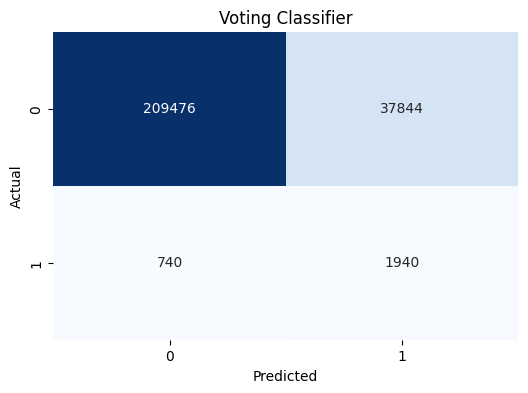

In [7]:
# create and display confusion matrix
cm = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Voting Classifier')
plt.show()

##### Looking at each individual model
---

Below we look at the performance metrics that each of the individual sub-models might generate and how those might impact the voting classifier results above.

In [8]:
regr = LogisticRegression()
regr.fit(X_train_resampled, y_train_resampled["fraud_bool"])

y_hat = regr.predict(X_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    247320
           1       0.04      0.74      0.08      2680

    accuracy                           0.82    250000
   macro avg       0.52      0.78      0.49    250000
weighted avg       0.99      0.82      0.89    250000



In [9]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train_resampled, y_train_resampled["fraud_bool"])
y_hat = clf.predict(X_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90    247320
           1       0.04      0.74      0.08      2680

    accuracy                           0.82    250000
   macro avg       0.52      0.78      0.49    250000
weighted avg       0.99      0.82      0.89    250000



In [10]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

nystroem = Nystroem(kernel='poly')
X_mapped = nystroem.fit_transform(X_train_resampled)

clf = SGDClassifier(loss='hinge')
clf.fit(X_mapped, y_train_resampled["fraud_bool"])

X_test_mapped = nystroem.transform(X_test)
y_hat = clf.predict(X_test_mapped)

print(classification_report(y_test["fraud_bool"], y_hat))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    247320
           1       0.04      0.75      0.08      2680

    accuracy                           0.82    250000
   macro avg       0.52      0.78      0.49    250000
weighted avg       0.99      0.82      0.89    250000



In [11]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

nystroem = Nystroem(kernel='rbf')
X_mapped = nystroem.fit_transform(X_train_resampled)

clf = SGDClassifier(loss='hinge')
clf.fit(X_mapped, y_train_resampled["fraud_bool"])

X_test_mapped = nystroem.transform(X_test)
y_hat = clf.predict(X_test_mapped)

print(classification_report(y_test["fraud_bool"], y_hat))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90    247320
           1       0.04      0.72      0.08      2680

    accuracy                           0.82    250000
   macro avg       0.52      0.77      0.49    250000
weighted avg       0.99      0.82      0.89    250000

